<a href="https://colab.research.google.com/github/Pankajjoshi11/walmart_retail_analysis/blob/main/ml_model_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pandas
import pandas as pd
df=pd.read_csv("/walmart_updated.csv")

In [4]:
# Import ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


**Final code to apply pipeline**

In [44]:
from sklearn.preprocessing import LabelEncoder

# Encode y
le = LabelEncoder()
y = le.fit_transform(df['rating_level'])

# Drop target leakage columns
X = df.drop(['rating', 'rating_level', 'invoice_id', 'date', 'time'], axis=1)


In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')


In [46]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Fit & transform preprocessing for SMOTE
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Apply SMOTE only to training
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)


In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Final pipeline (Preprocessing already applied before SMOTE)
model_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=5,
        min_samples_leaf=2, random_state=42
    ))
])

# Fit on resampled data
model_pipeline.fit(X_train_resampled, y_train_resampled)


Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=2,
                                        min_samples_split=5,
                                        random_state=42))])

In [48]:
from sklearn.metrics import classification_report

y_pred = model_pipeline.predict(X_test_processed)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

        High       0.99      0.85      0.92       161
         Low       0.97      1.00      0.98       844
      Medium       1.00      1.00      1.00       837

    accuracy                           0.99      1842
   macro avg       0.99      0.95      0.97      1842
weighted avg       0.99      0.99      0.99      1842



In [50]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Preprocess entire X
X_processed = preprocessor.fit_transform(X)

# Resample the entire dataset using SMOTE
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_processed, y)

# Cross-validation scores
cv_scores = cross_val_score(
    model_pipeline,
    X_resampled,
    y_resampled,
    cv=5,
    scoring='f1_macro',  # or 'accuracy'
    n_jobs=-1
)

# Print results
print(" 5-Fold Cross-Validation F1 Scores:", np.round(cv_scores, 4))
print(" Mean F1 Score:", round(cv_scores.mean(), 4))
print(" Std Dev:", round(cv_scores.std(), 4))


 5-Fold Cross-Validation F1 Scores: [0.928  0.998  0.9957 0.9957 0.9972]
 Mean F1 Score: 0.9829
 Std Dev: 0.0275


**Experimenting with pipelines**

In [51]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Full pipeline with SMOTE inside
smote_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=5,
        min_samples_leaf=2, random_state=42
    ))
])

# Fit on original (non-resampled) data
smote_pipeline.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['branch', 'city', 'category',
                                                   'payment_method'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=2,
                                        min_samples_split=5,
                                        random_state=42))])

In [52]:
y_pred = smote_pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

        High       0.99      0.85      0.92       161
         Low       0.97      1.00      0.98       844
      Medium       1.00      1.00      1.00       837

    accuracy                           0.99      1842
   macro avg       0.99      0.95      0.97      1842
weighted avg       0.99      0.99      0.99      1842



In [53]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(smote_pipeline, X, y, cv=5, scoring='f1_macro')
print("CV F1 Macro:", cv_scores.mean())


CV F1 Macro: 0.9142565529408664


**FEATURE ANALYSIS**

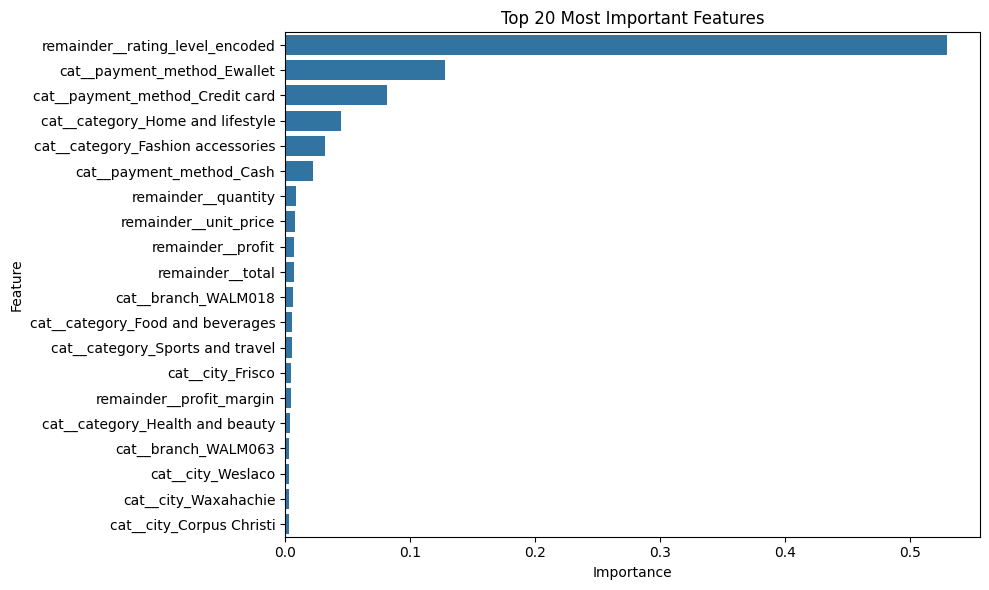

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use the best pipeline: smote_pipeline OR xgb_pipeline
model = smote_pipeline  # or xgb_pipeline

# Get feature names from preprocessor
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

# Get feature importances
importances = model.named_steps['classifier'].feature_importances_

# Create importance DataFrame
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi_df = fi_df.sort_values(by='importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=fi_df)
plt.title("Top 20 Most Important Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


**HYPER PARAMETER TUNING FOR RANDOMFOREST CLASSIFIER**

In [56]:
from sklearn.model_selection import GridSearchCV

# Use pipeline without fitted model
tuning_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define grid
param_grid = {
    'classifier__n_estimators': [100, 150],
    'classifier__max_depth': [8, 10, 12],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# GridSearch
grid_search = GridSearchCV(tuning_pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Results
print("🔍 Best Parameters:")
print(grid_search.best_params_)

print("\n✅ Classification Report with Best Estimator")
best_model = grid_search.best_estimator_
y_pred_gs = best_model.predict(X_test)
print(classification_report(y_test, y_pred_gs, target_names=le.classes_))


🔍 Best Parameters:
{'classifier__max_depth': 12, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}

✅ Classification Report with Best Estimator
              precision    recall  f1-score   support

        High       1.00      0.88      0.93       161
         Low       0.98      1.00      0.99       844
      Medium       1.00      1.00      1.00       837

    accuracy                           0.99      1842
   macro avg       0.99      0.96      0.97      1842
weighted avg       0.99      0.99      0.99      1842



**GRAPHS**



In [58]:
# Preprocess X_train
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# Apply SMOTE manually
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_prep, y_train)


/tmp/ipython-input-59-3103010779.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=le.inverse_transform(y), palette="Set2")


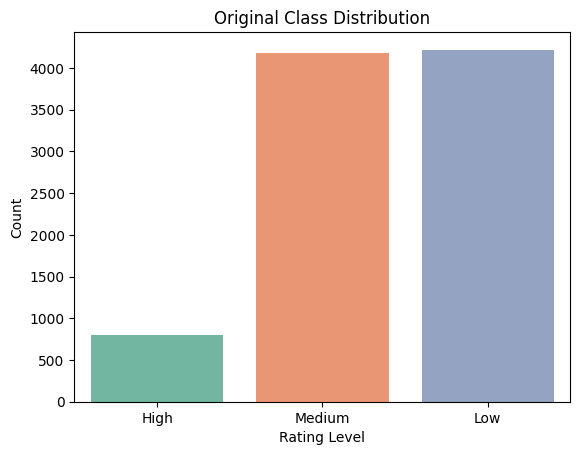

/tmp/ipython-input-59-3103010779.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=le.inverse_transform(y_train_res), palette="Set1")


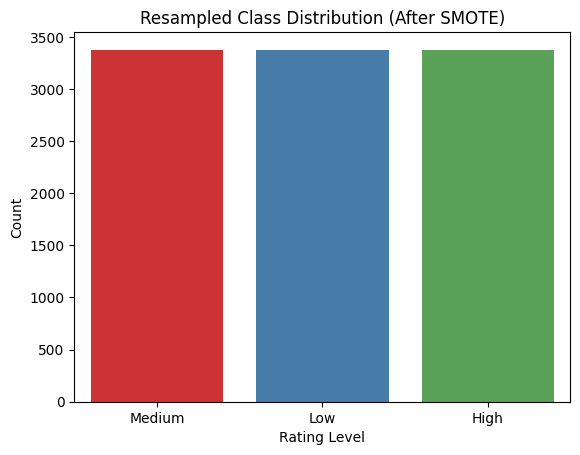

In [59]:
# Before SMOTE
sns.countplot(x=le.inverse_transform(y), palette="Set2")
plt.title("Original Class Distribution")
plt.xlabel("Rating Level")
plt.ylabel("Count")
plt.show()

# After SMOTE
sns.countplot(x=le.inverse_transform(y_train_res), palette="Set1")
plt.title("Resampled Class Distribution (After SMOTE)")
plt.xlabel("Rating Level")
plt.ylabel("Count")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


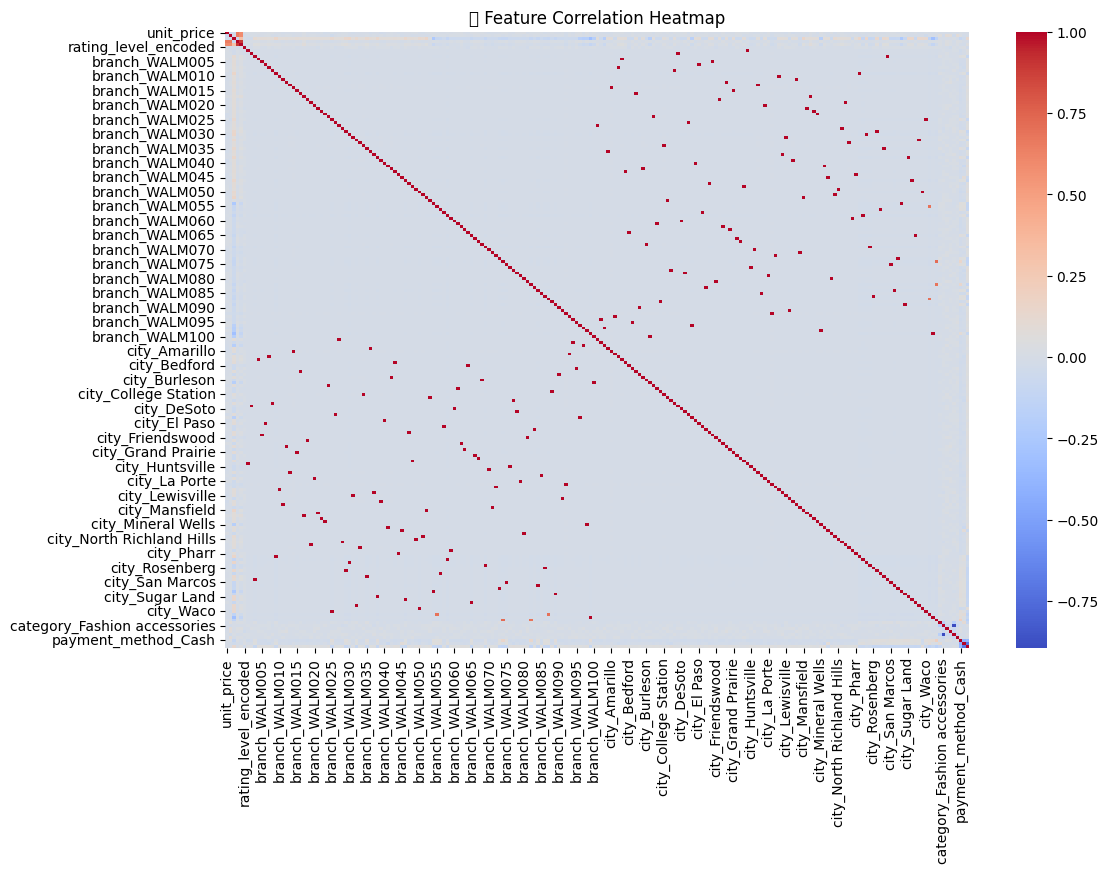

In [60]:
#correlation heatmap before modelling
# Convert categorical to dummy for correlation
df_corr = pd.get_dummies(df.drop(['rating', 'rating_level', 'invoice_id', 'date', 'time'], axis=1))
corr = df_corr.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("📌 Feature Correlation Heatmap")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


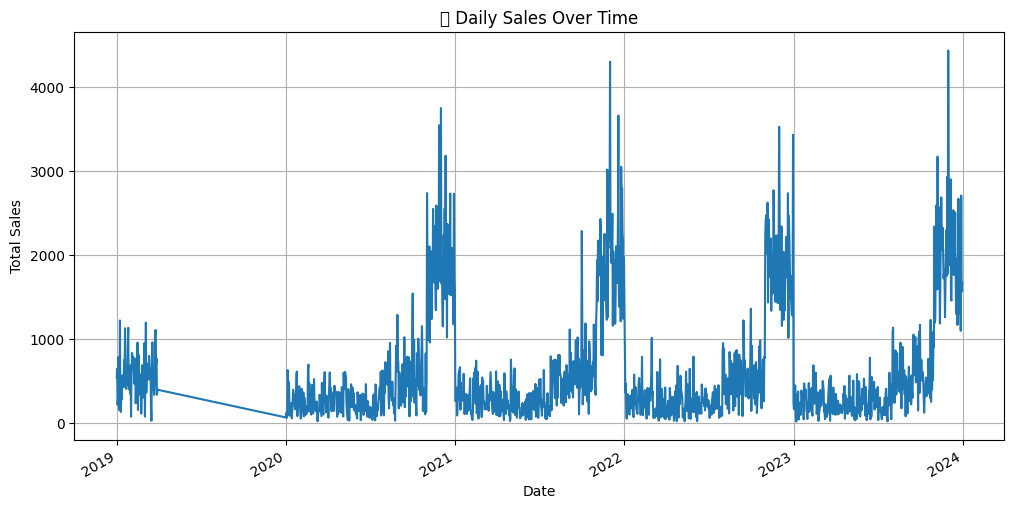

In [61]:
#sales trend overtime

# Convert to datetime and group
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%y')
daily_sales = df.groupby('date')['total'].sum()

plt.figure(figsize=(12,6))
daily_sales.plot()
plt.title("🗓️ Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


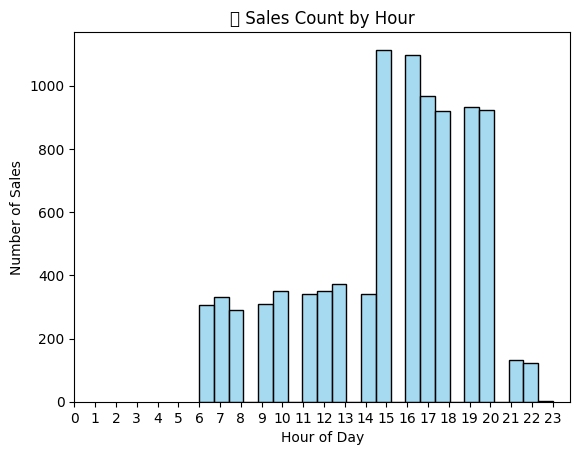

In [65]:
#sales by the hour of the day
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.hour
sns.histplot(df['hour'], bins=24, kde=False, color='skyblue')
plt.title("⏱️ Sales Count by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Sales")
plt.xticks(range(0,24))
plt.show()
